In [2]:
%pip install scikit-learn
%pip install psutil
%pip install exmatrix
%pip install shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached exmatrix-0.2.3-py3-none-any.whl.metadata (11 kB)
  Using cached lrmatrix-0.1.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached drawSvg-1.9.0-py3-none-any.whl.metadata (12 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached matplotlib-3.6.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached pydotplus-2.0.2-py3-none-any.whl
  Using cached CairoSVG-2.7.1-py3-none-any.whl.metadata (2.7 kB)
  Using cached cairocffi-1.7.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached cssselect2-0.7.0-py3-none-any.whl.metadata (2.9 kB)
Using cached exmatrix-0.2.3-py3-none-any.whl (9.3 kB)
Using cached lrmatrix-0.1.4-py3-none-any.whl (29 kB)
Using cached drawSvg-1.9.0-py3-none-any.whl (26 kB)
Using cached matplotlib-3.6.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB

# Binary classification on kdd99 corrected.csv

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from time import time
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings; warnings.filterwarnings('ignore')
import shap
import exmatrix
from lrmatrix.treevis import nodelink
#from exmatrix.treevis import nodelink


from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
help(exmatrix)
print(dir(exmatrix))


Help on package exmatrix:

NAME
    exmatrix

PACKAGE CONTENTS
    explainablematrix

FILE
    /opt/conda/lib/python3.11/site-packages/exmatrix/__init__.py


['ExplainableMatrix', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'explainablematrix']


In [3]:
#loading the data
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", 
             "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
             "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", 
             "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
             "srv_diff_host_rate", "dst_host_count","dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
             "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

#Initially, we will use all features
num_features = ["duration", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", 
                "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
                "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]

kdd_df = pd.read_csv("../KDD99/corrected.csv", names = col_names)
kdd_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,3.110290e+05,3.110290e+05,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,17.902736,1.731702e+03,7.479937e+02,0.000029,0.000762,0.000051,0.014677,0.002363,0.172476,0.011243,...,235.282681,199.193914,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,407.644400,1.276567e+05,1.612018e+04,0.005379,0.040367,0.009821,0.312068,0.049990,0.377794,1.958325,...,60.913298,100.306470,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,244.000000,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
len(num_features)

38

In [19]:
features = kdd_df[num_features].astype(float)
features.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,3.110290e+05,3.110290e+05,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,17.902736,1.731702e+03,7.479937e+02,0.000029,0.000762,0.000051,0.014677,0.002363,0.172476,0.011243,...,235.282681,199.193914,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,407.644400,1.276567e+05,1.612018e+04,0.005379,0.040367,0.009821,0.312068,0.049990,0.377794,1.958325,...,60.913298,100.306470,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,244.000000,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
#we are going to reduce the outputs to 'normal' and 'attack'
labels = kdd_df['label'].copy()
print(labels.value_counts())
labels_binary = kdd_df['label'].copy()
labels_binary[labels_binary != 'normal.'] = 'attack.'
val_count = labels_binary.value_counts()
labels_binary.value_counts()

label
smurf.              164091
normal.              60593
neptune.             58001
snmpgetattack.        7741
mailbomb.             5000
guess_passwd.         4367
snmpguess.            2406
satan.                1633
warezmaster.          1602
back.                 1098
mscan.                1053
apache2.               794
processtable.          759
saint.                 736
portsweep.             354
ipsweep.               306
httptunnel.            158
pod.                    87
nmap.                   84
buffer_overflow.        22
multihop.               18
named.                  17
sendmail.               17
ps.                     16
xterm.                  13
rootkit.                13
teardrop.               12
xlock.                   9
land.                    9
xsnoop.                  4
ftp_write.               3
perl.                    2
phf.                     2
udpstorm.                2
worm.                    2
loadmodule.              2
sqlattack.            

label
attack.    250436
normal.     60593
Name: count, dtype: int64

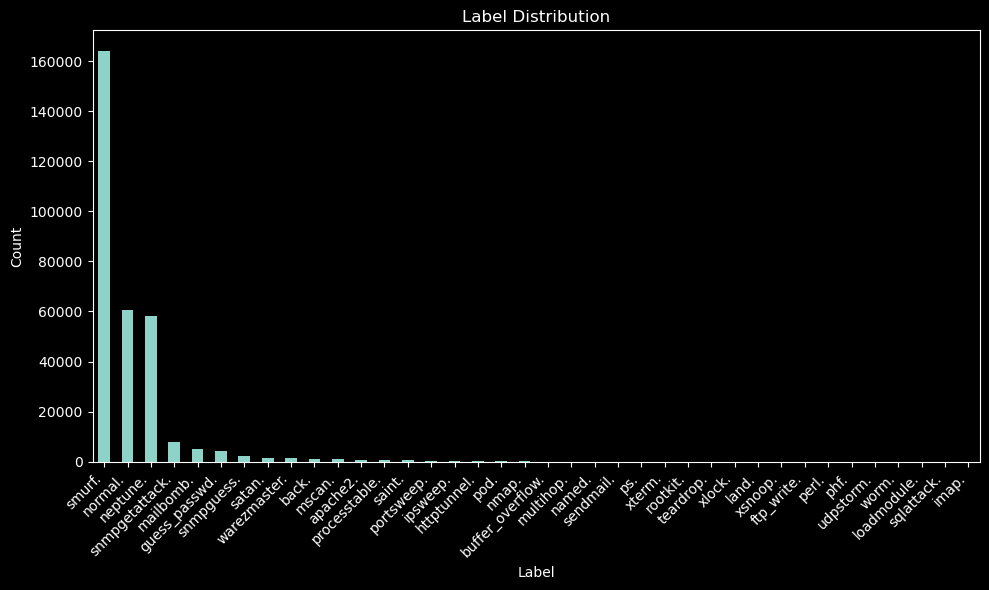

In [25]:
label_series = pd.Series(labels.value_counts())

# Create a bar chart
plt.figure(figsize=(10, 6))
label_series.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

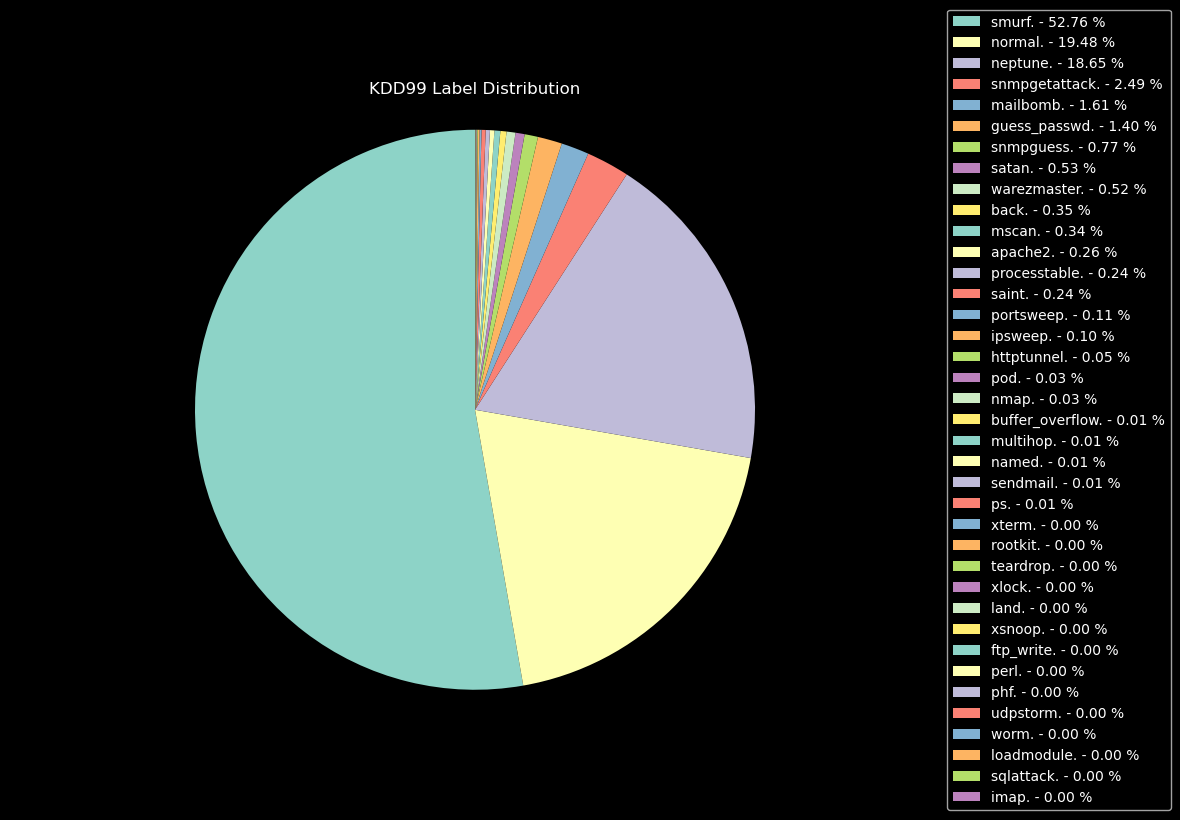

In [46]:
# Get labels and counts from the dictionary
labels = label_series.index
counts = label_series.values
percent = 100.*counts/counts.sum()

# Create a pie chart
plt.figure(figsize=(12, 8))
wedges, _ = plt.pie(counts, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.title('KDD99 Label Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, .5))
plt.savefig('KDD99_label_dist.png', bbox_inches='tight')
plt.show()

In [21]:
# Assuming 'features' is your DataFrame
scaler = MinMaxScaler()

# Apply Min-Max scaling to each column separately
features_scaled = features.copy()
for column in features.columns:
    column_data = features[column].values.reshape(-1, 1)
    features_scaled[column] = scaler.fit_transform(column_data)

# If you want to keep the scaled data in the original DataFrame
features_scaled.columns = features.columns
features_scaled.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,0.000310,0.000028,0.000144,0.000029,0.000254,0.000017,0.000145,0.000591,0.172476,0.000014,...,0.922677,0.781153,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,0.007063,0.002032,0.003098,0.005379,0.013456,0.003274,0.003090,0.012498,0.377794,0.002460,...,0.238876,0.393359,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.956863,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [537]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_binary, test_size=0.2, random_state=42)

In [538]:
#Training a classifier
#clf = RandomForestClassifier(n_estimators=optimal_n_trees, max_depth=optimal_max_depth, random_state = 0)
clf = RandomForestClassifier(random_state = 69)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 12.581 seconds.


In [539]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
#precision = precision_score(y_test, pred_test)
#recall = recall_score(y_test, pred_test)
#f1 = f1_score(y_test, pred_test)
#accuracy_train = accuracy_score(y_train, pred_train)
#accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
#print("Accuracy train: ", accuracy_train)
#print("Accuracy test: ", accuracy_test)
#print("Precision: ", precision)
#print("Recall: ", recall)
#rint("F1 Score: ", f1)

Classifier predicted on train set in 0.998 seconds.
Classifier predicted on test set in 0.234 seconds.


ValueError: pos_label=1 is not a valid label. It should be one of ['attack.', 'normal.']

Selected features: ['dst_bytes', 'count', 'logged_in', 'src_bytes', 'dst_host_count', 'dst_host_same_src_port_rate', 'srv_count', 'dst_host_diff_srv_rate', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate', 'dst_host_srv_count', 'same_srv_rate', 'dst_host_same_srv_rate', 'dst_host_rerror_rate', 'duration', 'diff_srv_rate', 'dst_host_srv_rerror_rate']
len original features 38
len selected features 17


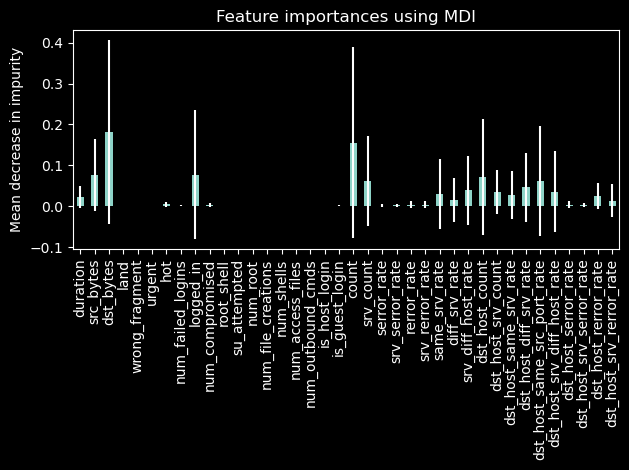

In [540]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features_scaled.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': features_scaled.columns, 'Importance': importances})

# Sort the DataFrame by importance scores in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

def select_important_features(feature_importance_df_sorted, threshold=0.01):
    important_features = feature_importance_df_sorted[feature_importance_df_sorted['Importance'] > threshold]
    selected_feature_names = important_features['Feature'].tolist()
    return selected_feature_names

# Usage:
selected_features = select_important_features(feature_importance_df_sorted, threshold=0.01)
print("Selected features:", selected_features)
print("len original features", len(num_features))
print("len selected features", len(selected_features))

# Non-binary classification

In [22]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

encoded_labels = labels.copy()

# Fit the encoder on the labels and transform the column
encoded_labels = label_encoder.fit_transform(encoded_labels)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, encoded_labels, test_size=0.2, random_state=42)

In [23]:
#Training a classifier
#clf = RandomForestClassifier(n_estimators=optimal_n_trees, max_depth=optimal_max_depth, random_state=0)
clf = RandomForestClassifier(random_state=0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 13.531 seconds.


In [24]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier predicted on train set in 7.487 seconds.
Classifier predicted on test set in 1.307 seconds.
Accuracy train:  0.9815009062667036
Accuracy test:  0.9810146931164196
Precision:  0.9810146931164196
Recall:  0.9810146931164196
F1 Score:  0.9810146931164196


In [77]:
encoded_labels_series = pd.Series(labels)

# Get the value counts
value_counts = encoded_labels_series.value_counts()

print(value_counts)

num_features_str = [str(feature) for feature in num_features]
value_counts_str = [str(count) for count in value_counts]

label
smurf.              164091
normal.              60593
neptune.             58001
snmpgetattack.        7741
mailbomb.             5000
guess_passwd.         4367
snmpguess.            2406
satan.                1633
warezmaster.          1602
back.                 1098
mscan.                1053
apache2.               794
processtable.          759
saint.                 736
portsweep.             354
ipsweep.               306
httptunnel.            158
pod.                    87
nmap.                   84
buffer_overflow.        22
multihop.               18
named.                  17
sendmail.               17
ps.                     16
xterm.                  13
rootkit.                13
teardrop.               12
xlock.                   9
land.                    9
xsnoop.                  4
ftp_write.               3
perl.                    2
phf.                     2
udpstorm.                2
worm.                    2
loadmodule.              2
sqlattack.            

In [84]:
help(exp.create_svg)

Help on method create_svg in module lrmatrix.explanation:

create_svg(draw_row_labels=False, draw_col_labels=False, **kwargs) method of lrmatrix.explanation.Explanation instance



In [80]:
tree = nodelink( clf.estimators_[1], out_file = None, max_depth = None,  feature_names = num_features, class_names = value_counts, label = 'all', filled = True, leaves_parallel = False, impurity = False, node_ids = True, proportion = True, rotate = False, rounded = True, special_characters = False, precision = 2 )
tree.write_svg( 'DT49.svg' )

TypeError: can only concatenate str (not "numpy.int64") to str

In [ ]:
exm = ExplainableMatrix(n_features=len(selected_features), n_classes=len(np.unique(encoded_labels)) , feature_names=num_features, class_names=y_true.unique())
exm.rules_extration(clf, X_test.to_numpy(), y_test, clf.feature_importances_)
print( 'n_rules DT', exm.n_rules_ )


In [ ]:
exp = exm.explanation( info_text = '\nmax-depth 3\n\naccuracy 0.91\nerror 0.09\n' )
exp.create_svg( draw_row_labels = True, draw_col_labels = True, draw_rows_line = True, draw_cols_line = True, col_label_degrees = 18, width = 1990, height = 640, margin_bottom = 150 )
exp.save( 'IrisFlowerGE-DT.png', pixel_scale = 10 )
exp.save( 'IrisFlowerGE-DT.svg' )
exp.display_jn()

In [ ]:
exp = exm.explanation( exp_type = 'local', x_k = X_test.iloc[12], r_order = 'delta change', f_order = 'importance', info_text = '\ninstance 13\n' )
exp.create_svg( draw_x_k = True, draw_row_labels = True, draw_col_labels = True, draw_rows_line = True, draw_cols_line = True, col_label_degrees = 10, width = 1890, height = 600, margin_bottom = 150 )
exp.save( 'IrisFlowerLE-13-DT.png', pixel_scale = 5 )
exp.save( 'IrisFlowerLE-13-DT.svg' )
exp.display_jn()

In [61]:
explainer = shap.TreeExplainer(clf, feature_names=num_features)
shap_values = shap_values_Tree_tr.shap_values(X_train.iloc[:100])
# np.abs(shap_values.sum(1) + explainer.expected_value - pred_test[:100]).max()

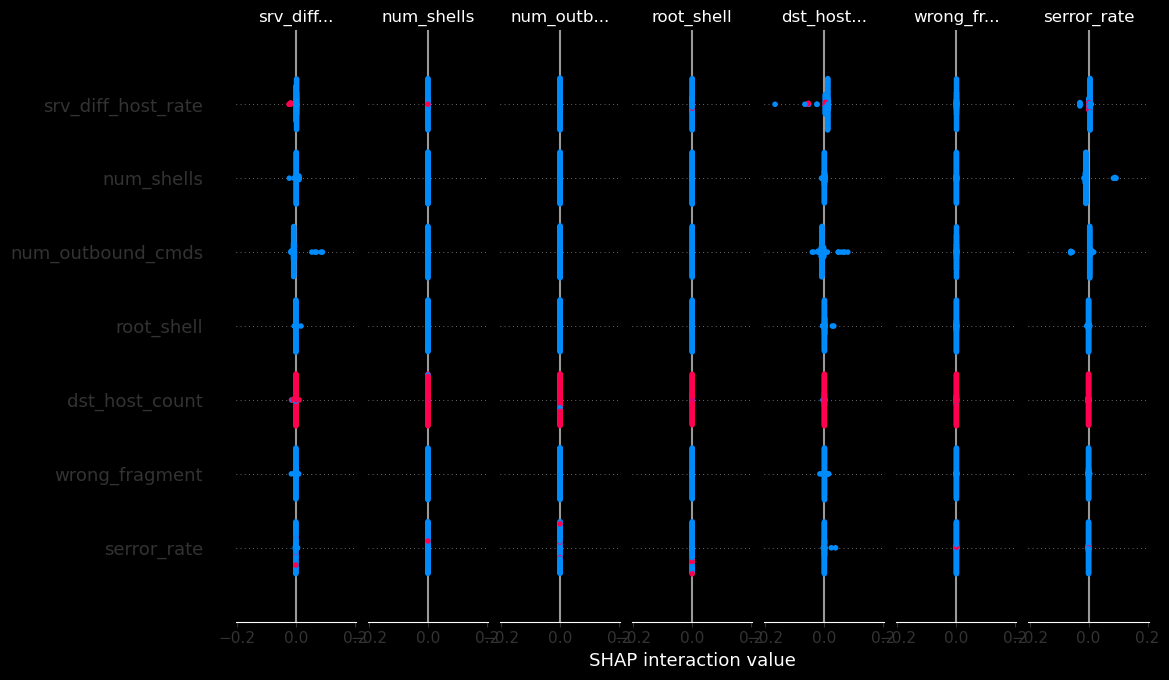

In [62]:
shap.summary_plot(shap_values, X_train.iloc[:100])

In [85]:
shap.plots.bar(shap_values)

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [58]:
shap_values_Tree_tr.explain_row(
    encoded_labels[2],
    shap_values[2, :],
    X_train.iloc[2, :],
)

TypeError: Explainer.explain_row() missing 5 required keyword-only arguments: 'max_evals', 'main_effects', 'error_bounds', 'outputs', and 'silent'

# Select n best features based on RF feature importance

Selected features: ['srv_count', 'src_bytes', 'dst_host_same_src_port_rate', 'count', 'dst_host_same_srv_rate', 'diff_srv_rate', 'dst_bytes', 'same_srv_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'logged_in', 'dst_host_rerror_rate', 'duration', 'dst_host_srv_rerror_rate', 'rerror_rate', 'dst_host_count']
len original features 38
len selected features 16


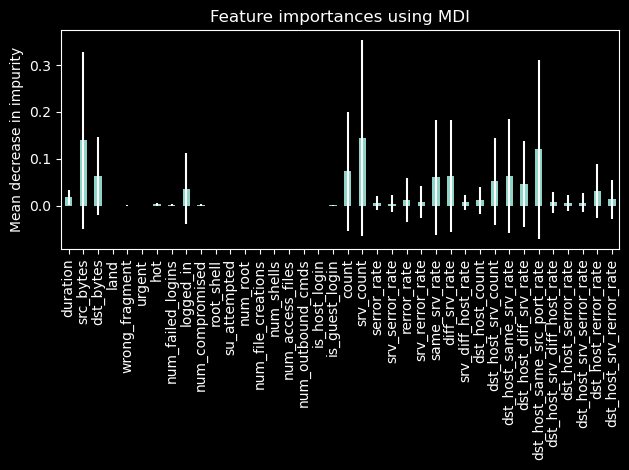

In [85]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances})

# Sort the DataFrame by importance scores in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

def select_important_features(feature_importance_df_sorted, threshold=0.01):
    important_features = feature_importance_df_sorted[feature_importance_df_sorted['Importance'] > threshold]
    selected_feature_names = important_features['Feature'].tolist()
    return selected_feature_names

# Usage:
selected_features = select_important_features(feature_importance_df_sorted, threshold=0.01)
print("Selected features:", selected_features)
print("len original features", len(num_features))
print("len selected features", len(selected_features))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled[selected_features], labels_binary, test_size=0.2, random_state=42)

In [21]:
#Training a classifier
#clf = RandomForestClassifier(n_estimators=optimal_n_trees, max_depth=optimal_max_depth, random_state = 0)
clf = RandomForestClassifier(random_state = 69)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 11.605 seconds.


In [22]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier predicted on train set in 0.812 seconds.
Classifier predicted on test set in 0.206 seconds.
Accuracy train:  0.9815330576353473
Accuracy test:  0.9811111468347105
Precision:  0.9811111468347105
Recall:  0.9811111468347105
F1 Score:  0.9811111468347105


# PCA to find the optimal number of principal components and getting accuracy

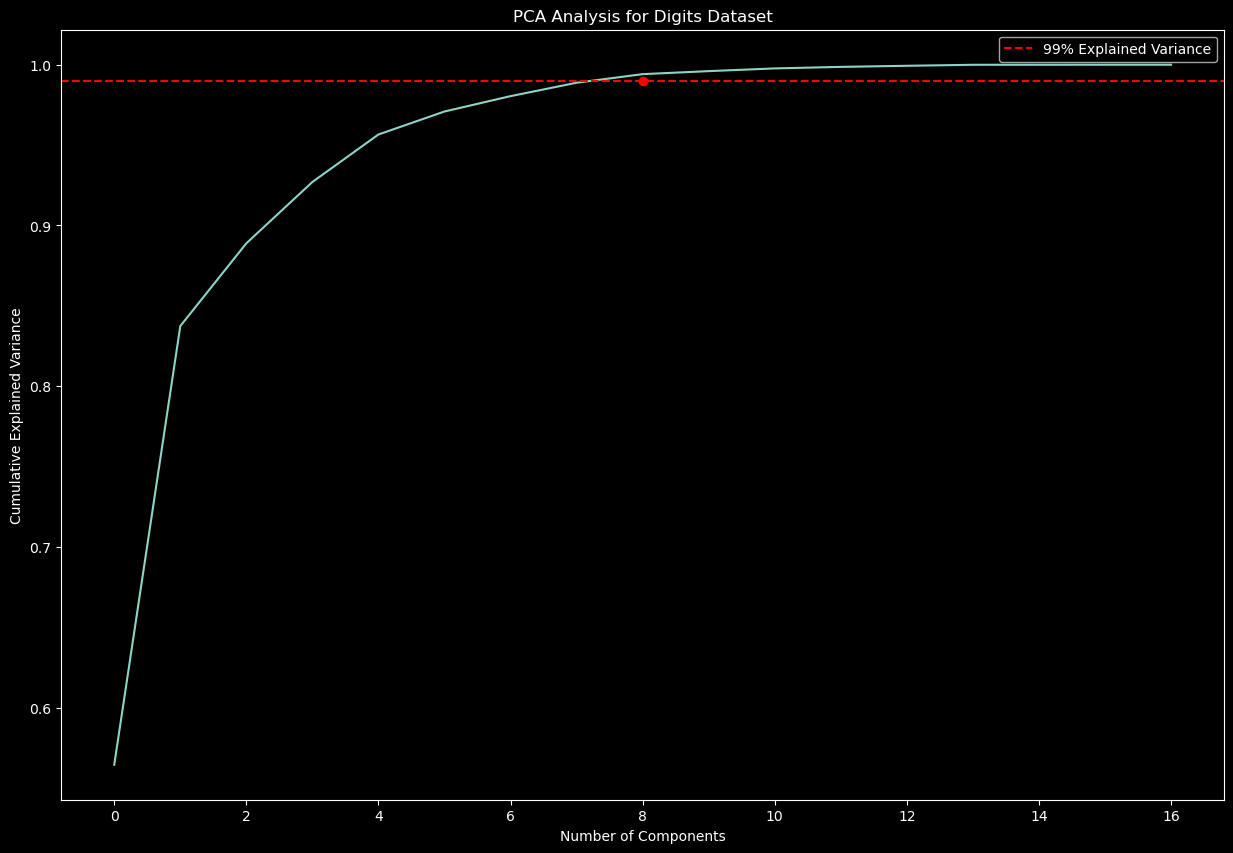

In [615]:
pca = PCA(whiten=True).fit(features_scaled[selected_features])

fig, ax = plt.subplots( figsize=(15, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis for Digits Dataset')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Explained Variance')
plt.legend()

# Find the index where cumulative explained variance first exceeds 95%
index_95_percent = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99)

# Add a marker at the 95% point
plt.scatter(index_95_percent, 0.99, color='r', marker='o')

# Annotate the point with text

plt.show()
index_95_percent = index_95_percent +1

In [10]:
print(index_95_percent)
pca = PCA(n_components=index_95_percent, whiten=True)
pca_result = pca.fit_transform(features_scaled)

10


In [70]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, labels, test_size=0.2, random_state=42)

In [71]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 27.288 seconds


In [72]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Optimal number of components: ", index_95_percent)

Classifier predicted on train set in 2.771 seconds.
Classifier predicted on test set in 0.553 seconds.
Accuracy train:  0.9758221707800324
Accuracy test:  0.9735877568080249
Precision:  0.9735877568080249
Recall:  0.9735877568080249
F1 Score:  0.9735877568080249
Optimal number of components:  10


# Selecting the best features

In [8]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

encoded_labels = labels.copy()
encoded_binary_labels = labels_binary.copy()

# Fit the encoder on the labels and transform the column
encoded_labels = label_encoder.fit_transform(encoded_labels)
encoded_binary_labels = label_encoder.fit_transform(encoded_binary_labels)

In [ ]:

combined_df = pd.concat([df1, df2], ignore_index=True)

In [ ]:
# Define a list of percentiles to test
percentiles = [10, 15, 20, 25, 30]

# Create a pipeline with feature selection and your classifier
model = make_pipeline(SelectPercentile(score_func=f_classif), RandomForestClassifier())

# Store accuracies for each percentile
accuracies = []

# Perform cross-validation for each percentile
for percentile in tqdm(percentiles):
    model.set_params(selectpercentile__percentile=percentile)
    scores = cross_val_score(model, features_scaled, labels, cv=5)
    accuracies.append(scores.mean())

# Print accuracies for each percentile
for percentile, accuracy in zip(percentiles, accuracies):
    print(f"Percentile: {percentile}, Mean Accuracy: {accuracy}")



# Initialize variables to store the optimal percentile and accuracy
optimal_percentile = None
optimal_accuracy = None

# Iterate through the percentiles and accuracies
for i in range(len(percentiles) - 1):
    gap_accuracy = accuracies[i+1] - accuracies[i]
    if gap_accuracy < 0.5:
        optimal_percentile = percentiles[i]
        optimal_accuracy = accuracies[i]
        break

# If no percentile meets the condition, choose the last one
if optimal_percentile is None:
    optimal_percentile = percentiles[-1]
    optimal_accuracy = accuracies[-1]

print(f"Optimal Percentile: {optimal_percentile}, Optimal Accuracy: {optimal_accuracy}")


In [19]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, encoded_labels, test_size=0.2, random_state=42)

In [20]:
selector = SelectPercentile(score_func=f_classif, percentile=optimal_percentile)

# Fit and transform the training set
X_train_selected = selector.fit_transform(X_train, y_train)

# Use the selected features to transform the test set
X_test_selected = selector.transform(X_test)

In [21]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train_selected, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 8.814 seconds


In [22]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train_selected)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test_selected)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("% feature selected", optimal_percentile)

Classifier predicted on train set in 2.687 seconds.
Classifier predicted on test set in 0.528 seconds.
Accuracy train:  0.9371079040120889
Accuracy test:  0.9312445744783462
Precision:  0.9312445744783462
Recall:  0.9312445744783462
F1 Score:  0.9312445744783462


# Select n best features based on RFECV

In [13]:
# Select at least 10% of the features
num_columns = len(kdd_df.columns)
min_features_to_select = int(num_columns * 0.1)

clf = RandomForestClassifier()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=2,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(features, labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 30


In [14]:
selected_feature_indices = rfecv.support_
selected_feature_names = [num_features[i] for i, selected in enumerate(selected_feature_indices) if selected]

print("Selected Features:", selected_feature_names)

reduced_df = features[selected_feature_names]

Selected Features: ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'num_root', 'num_file_creations', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [18]:
# Fit and transform the training set
X_train, X_test, y_train, y_test = train_test_split(reduced_df, labels, test_size=0.2, random_state=42)

In [19]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 13.889 seconds


In [22]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("N features selected", len(reduced_df.columns))

Classifier predicted on train set in 7.75 seconds.
Classifier predicted on test set in 1.415 seconds.
Accuracy train:  0.9815169819510254
Accuracy test:  0.981062919975565
Precision:  0.981062919975565
Recall:  0.981062919975565
F1 Score:  0.981062919975565
N features selected 30


In [21]:
len(num_features)

38

In [84]:
import psutil
# Measure memory usage before training the model
memory_before = psutil.virtual_memory().used

#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

# Measure memory usage after training the model
memory_after = psutil.virtual_memory().used

# Calculate the memory usage during the training process
memory_used = memory_after - memory_before

print(f"Memory used during training: {memory_used / 1024 / 1024:.2f} MB")

Trained in 12.016 seconds
Memory used during training: 94.74 MB


In [262]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

In [263]:
from sklearn.decomposition import PCA

def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

pca = PCA(n_components=10, random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled))

df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

In [264]:
scores = get_anomaly_scores(features_scaled, df_restored)
encoded_binary_labels[encoded_binary_labels == 1] = 5
encoded_binary_labels

,attack
0,5
1,5
2,5
3,0
4,0
...,...
311024,5
311025,5
311026,5
311027,5


In [265]:
print(scores)
print(encoded_binary_labels)

0         0.000276
1         0.000276
2         0.000276
3         0.000276
4         0.000272
            ...   
311024    0.000148
311025    0.000148
311026    0.000148
311027    0.000148
311028    0.000148
Length: 311029, dtype: float64
        attack
0            5
1            5
2            5
3            0
4            0
...        ...
311024       5
311025       5
311026       5
311027       5
311028       5

[311029 rows x 1 columns]


In [266]:
pca = PCA(whiten=True).fit(features_scaled)

# Find the index where cumulative explained variance first exceeds 95%
index_95_percent = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95)

index_99_percent = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99)

index_95_percent = index_95_percent +1
index_99_percent = index_99_percent +1

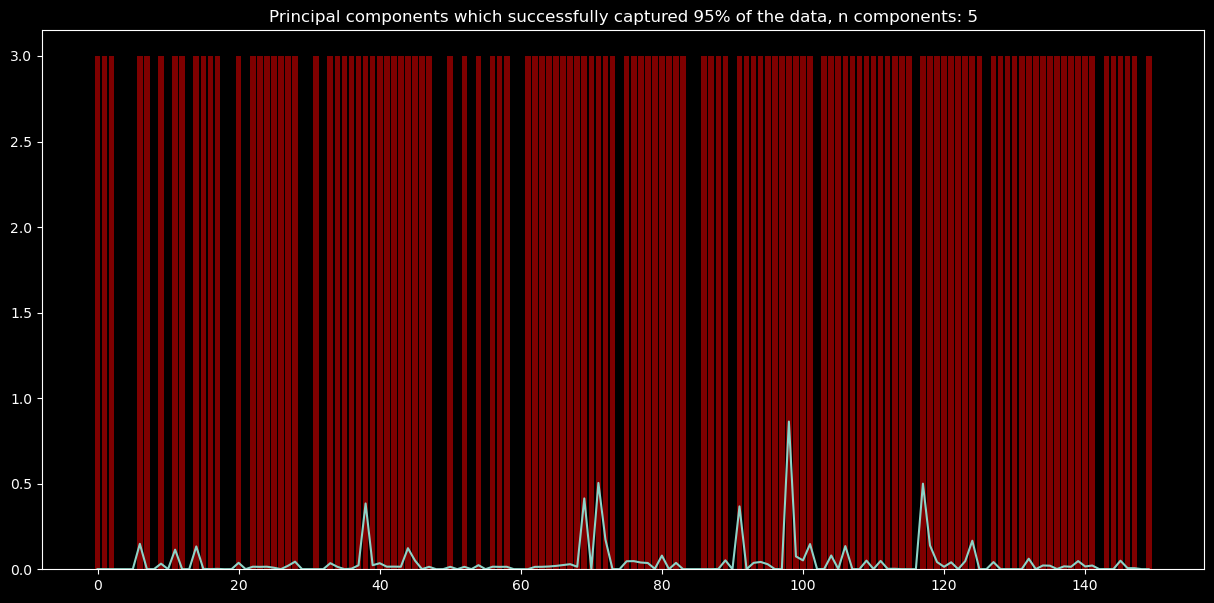

In [20]:
THRESHOLD = 150

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

encoded_labels = labels.copy()
encoded_binary_labels = labels_binary.copy()

# Fit the encoder on the labels and transform the column
encoded_labels = label_encoder.fit_transform(encoded_labels)
encoded_binary_labels = label_encoder.fit_transform(encoded_binary_labels)
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

pca = PCA(n_components=5, random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled.head(THRESHOLD)))

df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

scores = get_anomaly_scores(features_scaled.head(THRESHOLD), df_restored)
encoded_binary_labels[encoded_binary_labels == 1] = 3
encoded_binary_labels = encoded_binary_labels[:THRESHOLD]

plt.figure(figsize=(15, 7))
plt.plot(scores)
for i, val in enumerate(encoded_binary_labels):
    if val == 3:
        plt.bar(i, val, color='red', alpha=0.5)
plt.title("Principal components which successfully captured 95% of the data, n components: {}".format(5))
plt.savefig('../images/KDD99_pca_vs_groundtruth.png')
plt.show()

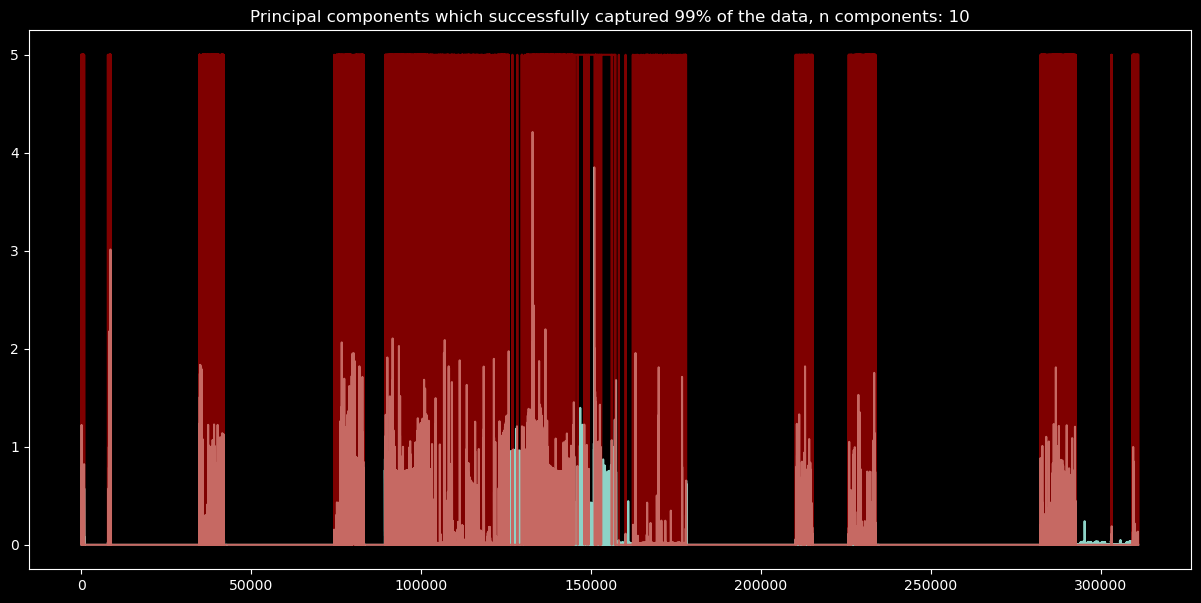

In [268]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

pca = PCA(n_components=index_99_percent, random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled))

df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

scores = get_anomaly_scores(features_scaled, df_restored)
encoded_binary_labels[encoded_binary_labels == 1] = 5

plt.figure(figsize=(15, 7))
plt.plot(scores)
plt.plot(encoded_binary_labels, alpha=0.5, color='red')# Larger figure size
plt.title("Principal components which successfully captured 99% of the data, n components: {}".format(index_99_percent))
plt.savefig('../images/KDD99_pca_vs_groundtruth_99.png')
plt.show()

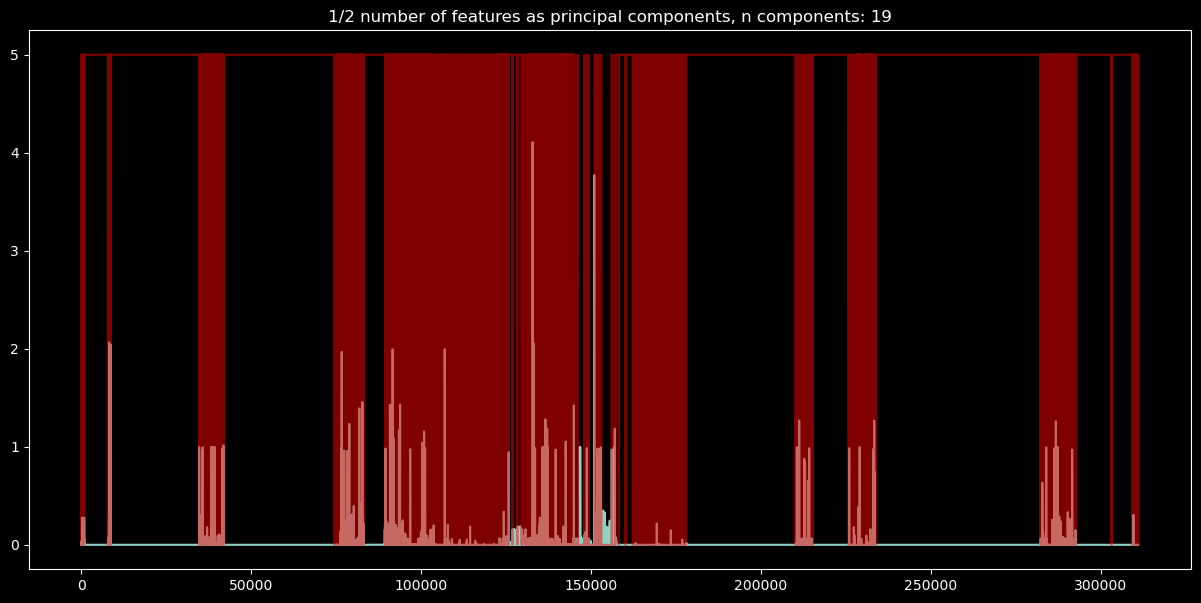

In [390]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

pca = PCA(n_components=(len(features_scaled.columns)//2), random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled))

df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

scores = get_anomaly_scores(features_scaled, df_restored)
encoded_binary_labels[encoded_binary_labels == 1] = 5

plt.figure(figsize=(15, 7))
plt.plot(scores)
plt.plot(encoded_binary_labels, alpha=0.5, color='red')# Larger figure size
plt.title("1/2 number of features as principal components, n components: {}".format((len(features_scaled.columns)//2)))

plt.savefig('../images/KDD99_pca_vs_groundtruth_50.png')
plt.show()

In [353]:
#scores = scores.values.tolist()
#print(scores[:1000])
#print(max(scores[:1000]))
print(scores)

0       3.502737e-05
1       3.502737e-05
2       3.502737e-05
3       3.502108e-05
4       3.434784e-05
            ...     
4995    1.550697e-09
4996    1.550697e-09
4997    1.550697e-09
4998    1.550697e-09
4999    1.550697e-09
Length: 5000, dtype: float64


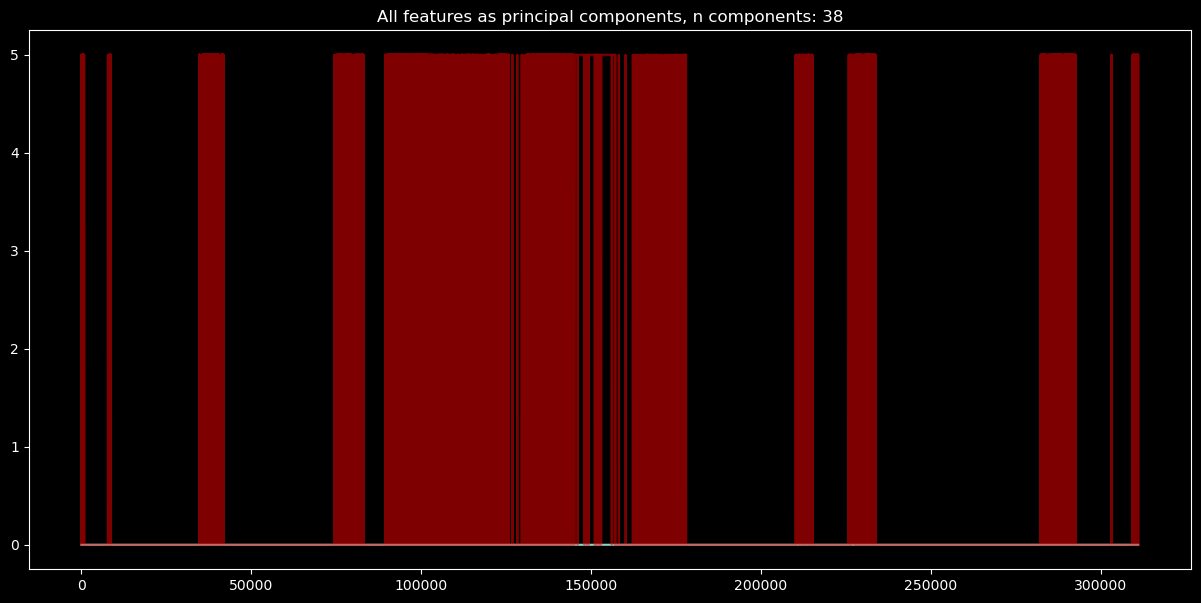

In [270]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

pca = PCA(n_components=len(features_scaled.columns), random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled))

df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

scores = get_anomaly_scores(features_scaled, df_restored)
encoded_binary_labels[encoded_binary_labels == 1] = 5

plt.figure(figsize=(15, 7))
plt.plot(scores)
plt.plot(encoded_binary_labels, alpha=0.5, color='red')# Larger figure size
plt.title("All features as principal components, n components: {}".format(len(features_scaled.columns)))

plt.savefig('../images/KDD99_pca_vs_groundtruth_100.png')
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_restored, labels, test_size=0.2, random_state=42)

In [13]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 45.105 seconds


In [14]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier predicted on train set in 2.819 seconds.
Classifier predicted on test set in 0.554 seconds.
Accuracy train:  0.9715580955136784
Accuracy test:  0.9696010031186703
Precision:  0.9696010031186703
Recall:  0.9696010031186703
F1 Score:  0.9696010031186703


In [542]:
labels_binary[labels_binary != 'normal.'] = 'attack.'
print(labels_binary.value_counts())

encoded_binary_labels = labels_binary.copy()

encoded_binary_labels[encoded_binary_labels != 'normal.'] = 1
encoded_binary_labels[encoded_binary_labels == 'normal.'] = 0
print(encoded_binary_labels.value_counts())

# Train PCA model
pca = PCA(n_components=(len(selected_features)//2), random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled[selected_features]))

org_df = features_scaled[selected_features].copy()

#X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_df, encoded_binary_labels, test_size=0.2, random_state=42)
#X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(org_df, encoded_binary_labels, test_size=0.2, random_state=42)

#X_train_pca.reset_index(drop=True, inplace=True)
#X_test_pca.reset_index(drop=True, inplace=True)
#X_train_org.reset_index(drop=True, inplace=True)
#X_test_org.reset_index(drop=True, inplace=True)
#y_train_pca.reset_index(drop=True, inplace=True)
#y_test_pca.reset_index(drop=True, inplace=True)
#y_train_org.reset_index(drop=True, inplace=True)
#y_test_org.reset_index(drop=True, inplace=True)

#clf = RandomForestClassifier(random_state = 0)
#t0 = time()
#clf.fit(org_df, encoded_binary_labels)
#tt = time() - t0
#print ("Trained in {} seconds".format(round(tt,3)))

label
attack.    250436
normal.     60593
Name: count, dtype: int64
label
1    250436
0     60593
Name: count, dtype: int64


In [ ]:
list_of_anomaly_preds = []
list_of_norm_preds = []
y_pred = []
y_true = []

def identify_anomaly(row, y):
    pred = clf.predict(row)
    anom_acc = accuracy_score(y, pred)  # Swap y and pred to calculate accuracy correctly
    list_of_anomaly_preds.append(anom_acc)
    return anom_acc
    
def get_loss(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    return loss

for index, row in pca_df.iterrows():
    inverse_row = pca.inverse_transform(row.values.reshape(1, -1))
    org_row = org_df.iloc[index].values.reshape(1, -1)  # Reshape org_row to 2D array
    org_y = encoded_binary_labels.iloc[index]  # Get the true label for this data point
    loss = get_loss(org_row, inverse_row)
    y_true.append(org_y)
    if loss > 0.01:
        #pred = identify_anomaly(org_row, org_y)
        y_pred.append(0)
        
    else:
        #norm_pred = clf.predict(org_row)
        #norm_acc = accuracy_score(org_y, norm_pred)  # Swap org_y and norm_pred to calculate accuracy correctly
        #list_of_norm_preds.append(norm_acc)
        y_pred.append(1)

In [632]:
labels_binary[labels_binary != 'normal.'] = 'attack.'
print(labels_binary.value_counts())

encoded_binary_labels = labels_binary.copy()

encoded_binary_labels[encoded_binary_labels != 'normal.'] = 1
encoded_binary_labels[encoded_binary_labels == 'normal.'] = 0
print(encoded_binary_labels.value_counts())

# Train PCA model
#pca = PCA(n_components=(len(features_scaled.columns)//2), random_state=0)
pca = PCA(n_components=index_95_percent, random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled))
df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

org_df = features_scaled.copy()

label
attack.    250436
normal.     60593
Name: count, dtype: int64
label
1    250436
0     60593
Name: count, dtype: int64


In [637]:
# Works, just low accuracy
# To improve performance -> windowed PCA, ... 

y_pred = []
y_true = []
loss_list = []
    
def get_loss(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    #loss = np.mean(np.abs(np.array(df_original) - np.array(df_restored)), axis=1)
    #loss = np.sqrt(np.mean((np.array(df_original) - np.array(df_restored)) ** 2, axis=1))
    loss = pd.Series(data=loss)
    return loss

for index, row in pca_df.iterrows():
    inverse_row = pca.inverse_transform(row.values.reshape(1, -1))
    org_row = org_df.iloc[index].values.reshape(1, -1) 
    org_y = encoded_binary_labels.iloc[index]  
    loss = get_loss(org_row, inverse_row)
    loss_list.append(loss)
    y_true.append(org_y)
    if np.array(loss) > 0.1:
        # High Loss -> anomaly
        y_pred.append(1)
    else:       
        # Low loss -> normal traffic
        y_pred.append(0)

In [643]:
def get_mse_loss(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss)
    return loss

def pca_anomaly_detector_mse(pca_df, org_df, loss_threshold):
    y_pred = []
    loss_list = []
    for i in range(len(pca_df)):
        inverse_row = pca_df.iloc[i].values.reshape(1, -1) 
        org_row = org_df.iloc[i].values.reshape(1, -1) 
        loss = get_mse_loss(org_row, inverse_row)
        if np.array(loss) > 0.1:
            # High Loss -> anomaly
            y_pred.append(1)
        else:       
            # Low loss -> normal traffic
            y_pred.append(0)
    return y_pred, loss_list

In [644]:
pca = PCA(n_components=index_95_percent, random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled))
df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=features_scaled.index)

y_pred_mse, loss_mse = pca_anomaly_detector_mse(df_restored, features_scaled, 0.1)

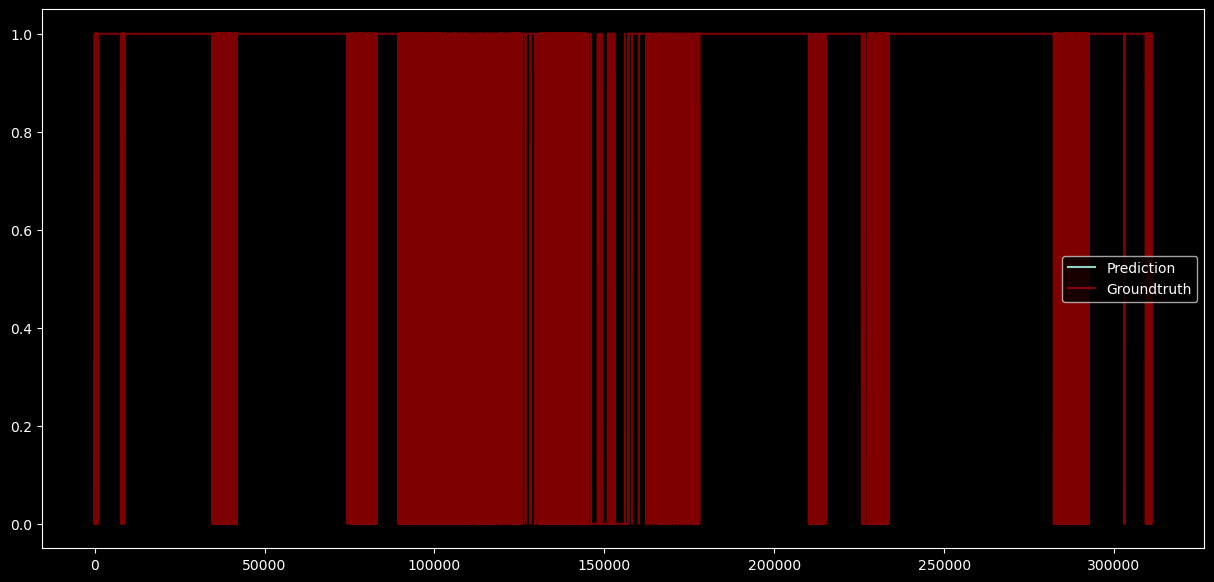

In [645]:
plt.figure(figsize=(15, 7))
plt.plot(loss_mse, label='Prediction')
plt.plot(y_true, alpha=0.5, color='red', label='Groundtruth')
plt.legend()
plt.show()

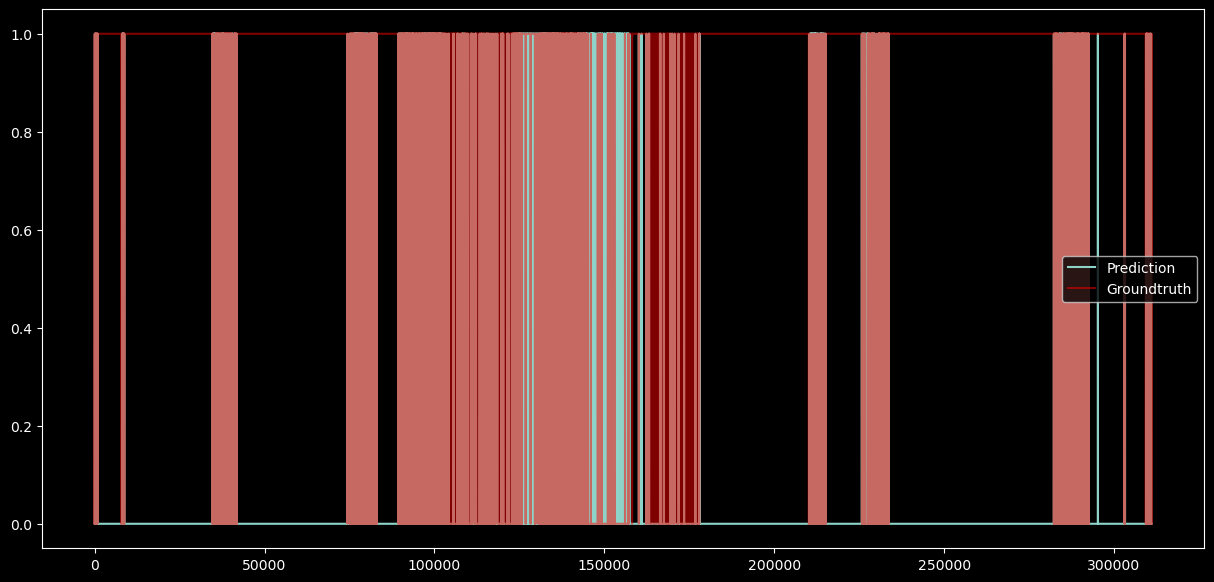

In [646]:
plt.figure(figsize=(15, 7))
plt.plot(y_pred_mse, label='Prediction')
plt.plot(y_true, alpha=0.5, color='red', label='Groundtruth')
plt.legend()
plt.show()

In [647]:
def calculate_tp_tn_fp_fn(y_t, y_p):
    y_t = np.array(y_t)
    y_p = np.array(y_p)
    
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    for true, pred in zip(y_t, y_p):
        if true == 1 and pred == 1:
            true_positives += 1
        elif true == 0 and pred == 0:
            true_negatives += 1
        elif true == 0 and pred == 1:
            false_positives += 1
        elif true == 1 and pred == 0:
            false_negatives += 1
    
    return true_positives, true_negatives, false_positives, false_negatives

tp, tn, fp, fn = calculate_tp_tn_fp_fn(y_true, y_pred_mse)
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = (tp)/(tp+fp)
recall = (tp)/(tp+fn)
f1_score = (2*tp)/(2*tp+fp+fn)

print("Accuracy train: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)
confusion_matrix(y_true, y_pred)

True Positives: 7872
True Negatives: 57668
False Positives: 2925
False Negatives: 242564
Accuracy train:  0.21071990071665342
Precision:  0.729091414281745
Recall:  0.03143318053315019
F1 Score:  0.06026803658037078


array([[ 51548,   9045],
       [231769,  18667]])

In [599]:
y_true

[0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,


In [600]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


In [490]:
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
#f1 = f1_score(y_true, y_pred, average='weighted')
accuracy_train = accuracy_score(y_true, y_pred)
# accuracy_test = accuracy_score(y_train_org, y_pred)

print("Accuracy train: ", accuracy_train)
# print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
#print("F1 Score: ", f1)

Accuracy train:  0.20699999035459715
Precision:  0.7448320413436692
Recall:  0.023019853375712756
